In [1]:
import pandas as pd 
import requests 
import numpy as np
from scipy.stats import norm
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
from urllib.parse import urlencode 

plt.style.use('ggplot')

# A/B
Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [2]:
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/12gk_ATEeBZm4A' 
 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
# загружаем файл в df 
download_response = requests.get(download_url) 
df = pd.read_csv(download_url, sep=';') 

In [3]:
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [4]:
#Для удобства переименуем названия групп [a, b] в [control, test]
df.testgroup = df.testgroup.replace(to_replace=['b', 'a'], value=['test', 'control'])

In [5]:
#Смотрю на размер тестовой и контрольной группы
df.testgroup.value_counts()

test       202667
control    202103
Name: testgroup, dtype: int64

In [6]:
#Процентное содержание в каждой группе
df.testgroup.value_counts(normalize=True)

test       0.500697
control    0.499303
Name: testgroup, dtype: float64

In [7]:
#Количество уникальных пользователей
df.user_id.nunique()

404770

In [8]:
#Размер группы
group_size = df.groupby('testgroup', as_index=False).agg({'revenue':'count'}) \
    .rename(columns={'revenue':'group_size'})

In [9]:
#Размер группы которая совершала покупку
pay_group_size = df.query('revenue > 0').groupby('testgroup', as_index=False).agg({'revenue':'count'}) \
    .rename(columns={'revenue':'pay_group_size'})

In [10]:
KPI = group_size.merge(pay_group_size, on='testgroup')

In [11]:
#Конверсия в покупку
KPI['CR']= KPI.pay_group_size/KPI.group_size

In [12]:
#Выручка
revenue = df.groupby('testgroup', as_index=False).agg({'revenue':'sum'})

In [13]:
#Мерджим выручку к KPI
KPI = KPI.merge(revenue, on='testgroup')

In [14]:
#Средний доход на платящего пользователя
KPI['ARPPU'] = KPI.revenue/KPI.pay_group_size

In [15]:
#Средний доход на пользователя
KPI['ARPU'] = KPI.CR*KPI.ARPPU

In [16]:
#Вывожу ключевые показатели эффективности для тестов
KPI

,testgroup,group_size,pay_group_size,CR,revenue,ARPPU,ARPU
0,control,202103,1928,0.009540,5136189,2663.998444,25.413720
1,test,202667,1805,0.008906,5421603,3003.658172,26.751287


# Выводы по основным показателям:
    Если считать что выборки в контрольной и тестовой группе равны и все пользователи уникальны(т.е нету людей которые совершали повторные покупки), то тестовая группа показывает себя лучше, т.к выручка и средний доход с пользователя увеличились на 5%, а средний доход с платящего пользователя увечилися на 13%. Но конверсия в покупателя в контрольной группе на 7% больше. Для дальнейшего анализа необходимо посмотреть как распределяются значения в наших группах и провести тест, что бы понять не случайным ли образом у нас получились такие различия в группах.

# Тестовая группа

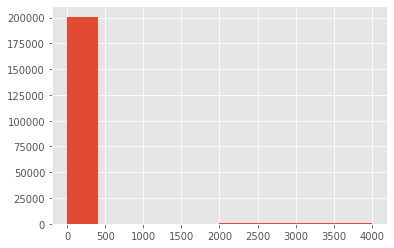

In [17]:
#Распределение для тестовой группы
df.query('testgroup == "test"').revenue.hist()

In [18]:
#Смотрю максимальный чек в тестовой группе 
df.query('testgroup == "test" & revenue > 1000').revenue.max()

4000

In [19]:
#Смотрю минимальный чек в тестовой группе
df.query('testgroup == "test" & revenue > 1000').revenue.min()

2000

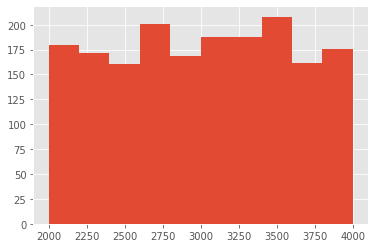

In [20]:
#Распределение для пользователей из тестовой которые совершали покупки
df.query('testgroup == "test" & revenue>1000').revenue.hist()

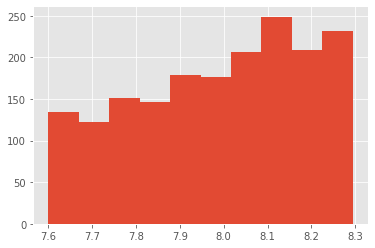

In [21]:
#Логарифмирую чтобы посмотреть не получится ли нормальное распределение
np.log(df.query('testgroup == "test" & 1500<revenue<5000').revenue).hist()

# Контрольная группа

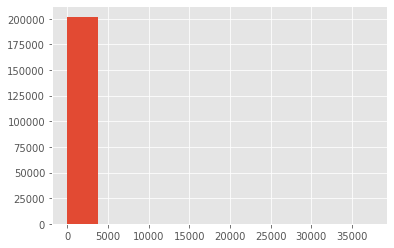

In [22]:
#Распределение для контрольной группы
df.query('testgroup == "control"').revenue.hist()

In [23]:
#Смотрю максимальный чек в контрольной группе 
df.query('testgroup == "control" & revenue > 1000').revenue.max()

37433

In [24]:
#Смотрю минимальный чек в контрольной группе при чеке больше 1000
df.query('testgroup == "control" & revenue > 1000').revenue.min()

37293

In [25]:
#Количество пользователей которые совершили крупную покупку от 37293 до 37433
df.query('testgroup == "control" & revenue > 1000').revenue.count()

123

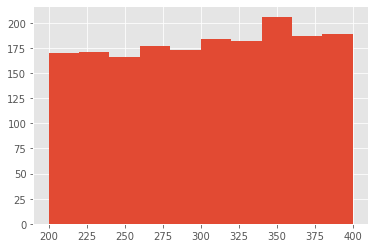

In [26]:
#Распределение для пользователей из контрольной группы которые совершали покупки от 0 до 500
df.query('testgroup == "control" & 0<revenue<5000').revenue.hist()

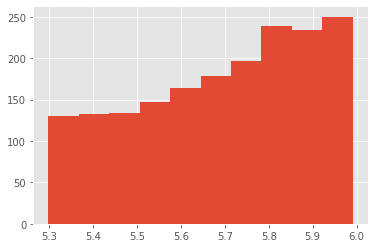

In [27]:
#Логарифмирую чтобы посмотреть не получится ли нормальное распределение
np.log(df.query('testgroup == "control" & 0<revenue<5000').revenue).hist()

# Выводы по распределениям
    В тестовой и контрольных группах мы видим большое количество пользователей которые не совершали покупки, из-за этого наше распределение сильно скошено в левую сторону. После избавление от таких пользователей мы наблюдаем:
    
    1)В тестовой группе пользователи в количестве 1805 человек совершали покупки от 2000 до 4000
    2)В контрольной группе основная масса пользователей совершала покупки от 200 до 400, а так же появился явный хвост с пользователями в количестве 123, которые совершали крупные покупки от 37293 до 37433. Для более детальной оценки что это за пользователи и не баг ли это, необходимо больше информации о данных.
    
    Распределения в наших группах не нормальное, а следовательно и распределение средних не нормальное, что не дает нам возпользоваться Т-тестом для проверки различия наших выборок. Но мы можем воспользоваться бутстрепом и тестом Манна-Витней, установив порог уровня значимости на 5%.
    

# Провожу тест на полных группах

In [28]:
df

,user_id,revenue,testgroup
0,1,0,test
1,2,0,control
2,3,0,control
3,4,0,test
4,5,0,test
...,...,...,...
404765,404766,0,control
404766,404767,0,test
404767,404768,231,control
404768,404769,0,control


In [29]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [30]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

In [31]:
n = 1000

sample_1 = np.random.exponential(scale=1/0.001, size=n)
sample_2 = np.random.exponential(scale=1/0.00101, size=n)

df1 = pd.DataFrame({
    "sample_1": sample_1,
    "sample_2": sample_2
})

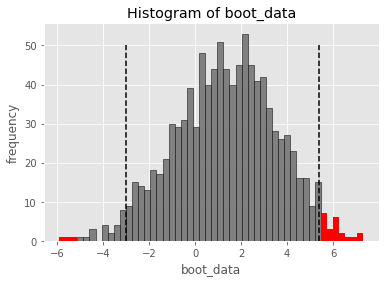

{'boot_data': [-4.036379874375206,
  2.7518786975679315,
  -2.22222167397751,
  2.3758678028490086,
  1.1656658459443323,
  1.9548273769286564,
  2.740544834630206,
  1.8143851737085959,
  0.81162695456093,
  -1.7595069744951077,
  3.069315675467639,
  2.130593535208001,
  1.1596214479910394,
  -0.4445667030152911,
  2.2045670977514837,
  2.9246695317935334,
  0.33278234739745494,
  0.8259657467668639,
  1.54268825215748,
  3.706271864684433,
  0.18655725895187672,
  0.8061055820631874,
  3.7575234251259455,
  1.5860549571464522,
  2.8608801630260476,
  0.9840526578081286,
  0.39760296446880844,
  3.214465107787652,
  2.9818914771521756,
  0.07727454395634217,
  3.491555112573828,
  1.1664158447107817,
  3.0586479298553786,
  4.192058894639976,
  2.874044615058199,
  3.4776258591679947,
  -0.2818021680885393,
  4.292168927353738,
  2.5474645600911843,
  3.216458525561636,
  -3.128980051019653,
  2.2668219295691947,
  6.219058850232154,
  -0.510270542318187,
  0.6059545954694153,
  3.02

In [32]:
#Провожу бусттрап для средней статистики
get_bootstrap(
    df[df.testgroup == 'test'].revenue, # числовые значения первой выборки
    df[df.testgroup == 'control'].revenue, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

In [33]:
#Проводим тест по Mann-Whitney
mannwhitneyu(df[df.testgroup == 'test'].revenue, 
             df[df.testgroup == 'control'].revenue)

MannwhitneyuResult(statistic=20468349325.0, pvalue=0.06269701316074398)

# Выводы:
    Бутстрап на средних значениях и тест Манна-Витней показывают значение уровня значимости больше 5%, следовательно мы не можем отклонить нулевую гиппотезу о том что в контрольной и тестовой группе нет различий. Бутстрап на медианных значениях не имеет смысла проводить, т.к основная масса пользователей не совершала покупки и медианы в обеих выборках будет равна 0.

# Тест для пользователей которые совершали покупки.

In [34]:
pay_users = df.query('revenue > 0')

In [35]:
pay_users

,user_id,revenue,testgroup
72,73,351,control
160,161,3797,test
341,342,290,control
377,378,3768,test
385,386,250,control
...,...,...,...
404315,404316,262,control
404525,404526,3120,test
404543,404544,369,control
404602,404603,251,control


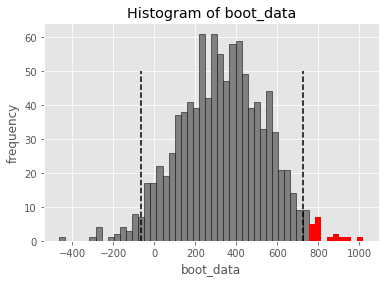

{'boot_data': [499.53267634854774,
  333.9128630705394,
  302.5119294605809,
  549.7826763485477,
  247.99429460580913,
  484.6841286307054,
  285.7795643153527,
  206.10010373443984,
  277.3039419087137,
  150.09751037344398,
  -278.3973029045643,
  11.302904564315353,
  59.70020746887967,
  417.85114107883817,
  104.56379668049793,
  -62.981327800829874,
  585.4834024896265,
  11.255186721991702,
  427.9932572614108,
  648.0285269709543,
  39.726141078838175,
  442.61151452282155,
  137.04149377593362,
  241.49948132780082,
  392.673755186722,
  571.7116182572614,
  0.25363070539419086,
  403.76815352697093,
  731.9439834024896,
  390.82365145228215,
  -38.064834024896264,
  364.8661825726141,
  195.86825726141078,
  564.201244813278,
  249.32209543568464,
  207.62551867219918,
  242.74948132780082,
  375.6400414937759,
  229.08195020746888,
  468.8978215767635,
  286.2157676348548,
  457.2811203319502,
  338.46628630705396,
  491.4190871369295,
  580.7100622406639,
  421.61618257261

In [37]:
#Провожу бусттрап для средней статистики
get_bootstrap(
    pay_users[pay_users.testgroup == 'test'].revenue, # числовые значения первой выборки
    pay_users[pay_users.testgroup == 'control'].revenue, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

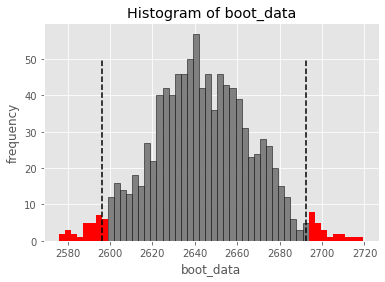

{'boot_data': [2624.0,
  2660.5,
  2642.5,
  2606.0,
  2637.0,
  2645.0,
  2663.5,
  2677.5,
  2632.0,
  2652.0,
  2662.0,
  2622.0,
  2657.0,
  2663.0,
  2630.5,
  2647.0,
  2663.5,
  2633.5,
  2667.0,
  2663.5,
  2661.5,
  2645.5,
  2653.0,
  2654.0,
  2657.5,
  2698.0,
  2649.0,
  2661.0,
  2660.0,
  2637.5,
  2596.5,
  2622.5,
  2647.0,
  2644.5,
  2646.5,
  2592.0,
  2642.0,
  2621.5,
  2642.0,
  2626.5,
  2665.5,
  2666.5,
  2626.0,
  2665.0,
  2640.0,
  2623.0,
  2641.5,
  2642.0,
  2626.5,
  2640.0,
  2665.0,
  2643.5,
  2622.0,
  2663.0,
  2636.0,
  2668.5,
  2659.0,
  2627.5,
  2672.0,
  2656.5,
  2639.0,
  2621.5,
  2601.5,
  2628.0,
  2641.0,
  2660.5,
  2662.0,
  2640.5,
  2632.0,
  2682.0,
  2610.5,
  2644.0,
  2680.5,
  2639.0,
  2648.0,
  2667.5,
  2624.0,
  2658.0,
  2646.0,
  2695.0,
  2652.0,
  2683.0,
  2671.0,
  2661.5,
  2659.0,
  2621.5,
  2674.0,
  2640.0,
  2604.5,
  2619.5,
  2673.0,
  2694.0,
  2663.5,
  2640.5,
  2652.0,
  2628.0,
  2662.5,
  2674.5,
  2638.

In [38]:
#Провожу бусттрап для медианной статистики
get_bootstrap(
    pay_users[pay_users.testgroup == 'test'].revenue, # числовые значения первой выборки
    pay_users[pay_users.testgroup == 'control'].revenue, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

In [40]:
#Проводим тест по Mann-Whitney
mannwhitneyu(pay_users[pay_users.testgroup == 'test'].revenue, 
             pay_users[pay_users.testgroup == 'control'].revenue)

MannwhitneyuResult(statistic=3258025.0, pvalue=0.0)

# Выводы : 
    Как уже было сказано ране контрольная группа имеет сильный хвост людей которые совершали дорогостоющие покупки, поэтому при проведениее бутстрапа логичнее отталкиваться от медианных значений, которые стат. значимо показали отличия в наших выборках, что и подтвердил тест Манна-Витней. Но что бы дать ответ какая из этих групп лучше, необходимо узнать как планировался эксперимент(по какому параметру мы бы хотели увидеть изменения, порог значимости, мощность, а так же убедиться соблюдается ли количество пользователей для эксперимента). Если брать только платящих пользователей, то тестовая группа показала себя гораздо лучше, чек увеличился от (200...400) до (2000...4000), ARPPU выросло на 13%, ARPU на 5%, так же было бы интересно получить более детальные данные о пользователях, которые совершали крупные покупки. Но при рассмотрении только платящих пользователей мы не учитываем конверсию в покупку, которая в контрольной группе на 7 процентов выше чем в тестовой. На основании имеющихся данных я бы поcоветовал (если это возможно увеличить конверсию) и выбрать тестовый вариант.